# Trader Behavior vs Market Sentiment Analysis  
### Primetrade.ai – Data Science Intern Assignment


## Executive Summary

This analysis investigates how Bitcoin market sentiment (Fear/Greed Index) influences trader behavior and performance on Hyperliquid. 

Using daily sentiment data and trade-level historical transaction data, we aggregate trader activity into daily performance and behavioral metrics such as PnL, trade frequency, position size, and directional bias.

We then compare trader performance across sentiment regimes to determine whether Fear and Greed conditions affect profitability and risk-taking behavior.

Preliminary findings indicate that trader behavior shifts meaningfully across regimes, particularly in trade frequency and risk exposure, suggesting opportunities for sentiment-aware trading strategies and dynamic risk management.


##  Business Understanding

###  Problem Statement

The objective of this analysis is to evaluate how market sentiment (Fear vs Greed) impacts trader behavior and performance on Hyperliquid.

Specifically, we aim to understand:

- Whether trader profitability differs across sentiment regimes.
- Whether traders adjust their risk exposure during Fear or Greed periods.
- Which trader segments are most sensitive to sentiment shifts.

Understanding this relationship can help design sentiment-aware trading rules and risk management strategies.


---

###  Hypotheses

We test the following hypotheses:

**H1:** Trader profitability (PnL and win rate) differs significantly between Fear and Greed regimes.

**H2:** Traders increase risk exposure (trade frequency, position size, leverage) during Greed regimes.

**H3:** High-leverage or aggressive traders are more sensitive to sentiment changes compared to conservative traders.

These hypotheses guide the feature engineering and analysis performed in this notebook.


### 1. Data Loading & Initial Inspection


In [18]:
# Standard Libraries
import pandas as pd
import numpy as np

# Visualization (for later sections)
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings for readability
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries imported successfully.")

Libraries imported successfully.


In [55]:
# Load datasets
df_sentiment = pd.read_csv("fear_greed_index.csv")
df_trades = pd.read_csv("historical_data.csv")

print("Datasets loaded successfully.")


Datasets loaded successfully.


In [39]:
print("Sentiment Dataset Shape:", df_sentiment.shape)
print("Trader Dataset Shape:", df_trades.shape)

# Preview First Few Rows
print("\n--- Sentiment Dataset Preview ---")
display(df_sentiment.head())

print("\n--- Trader Dataset Preview ---")
display(df_trades.head())

Sentiment Dataset Shape: (2644, 4)
Trader Dataset Shape: (211224, 16)

--- Sentiment Dataset Preview ---


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



--- Trader Dataset Preview ---


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.8700,7872.1600,BUY,02-12-2024 22:50,0.0000,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.3454,895000000000000.0000,1730000000000.0000
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.0000,127.6800,BUY,02-12-2024 22:50,986.5246,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0056,443000000000000.0000,1730000000000.0000
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.0900,1150.6300,BUY,02-12-2024 22:50,1002.5190,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0504,660000000000000.0000,1730000000000.0000
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.9800,1142.0400,BUY,02-12-2024 22:50,1146.5586,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0500,1080000000000000.0000,1730000000000.0000
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.7300,69.7500,BUY,02-12-2024 22:50,1289.4885,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0031,1050000000000000.0000,1730000000000.0000


In [56]:
# Dataset Information (Data Types & Nulls)
print("\n--- Sentiment Dataset Info ---")
df_sentiment.info()

print("\n--- Trader Dataset Info ---")
df_trades.info()

# Missing Values Check
print("\n--- Missing Values: Sentiment Dataset ---")
print(df_sentiment.isnull().sum())

print("\n--- Missing Values: Trader Dataset ---")
print(df_trades.isnull().sum())




--- Sentiment Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

--- Trader Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     

In [57]:
# Duplicate Check
print("\n--- Duplicate Rows ---")
print("Sentiment Dataset Duplicates:", df_sentiment.duplicated().sum())
print("Trader Dataset Duplicates:", df_trades.duplicated().sum())

# Basic Descriptive Statistics
print("\n--- Sentiment Dataset Summary ---")
display(df_sentiment.describe(include='all'))
print("\n--- Trader Dataset Numerical Summary ---")
display(df_trades.describe())

#Unique Traders Count
unique_accounts = df_trades['Account'].nunique()
print(f"Number of Unique Traders (Accounts): {unique_accounts}")


--- Duplicate Rows ---
Sentiment Dataset Duplicates: 0
Trader Dataset Duplicates: 0

--- Sentiment Dataset Summary ---


,timestamp,value,classification,date
count,2644.0000,2644.0000,2644,2644
unique,NaN,NaN,5,2644
top,NaN,NaN,Fear,2018-02-01
freq,NaN,NaN,781,1
mean,1631898885.0227,46.9811,NaN,NaN
std,65979674.3222,21.8277,NaN,NaN
min,1517463000.0000,5.0000,NaN,NaN
25%,1574811000.0000,28.0000,NaN,NaN
50%,1631899800.0000,46.0000,NaN,NaN
75%,1688988600.0000,66.0000,NaN,NaN



--- Trader Dataset Numerical Summary ---


,Execution Price,Size Tokens,Size USD,Start Position,Closed PnL,Order ID,Fee,Trade ID,Timestamp
count,211224.0000,211224.0000,211224.0000,211224.0000,211224.0000,211224.0000,211224.0000,211224.0000,211224.0000
mean,11414.7233,4623.3650,5639.4512,-29946.2488,48.7490,69653876008.9702,1.1640,562854854500788.5625,1737744290421.5430
std,29447.6549,104272.8895,36575.1385,673807.4237,919.1648,18357525271.9260,6.7589,325756470346550.3125,8689920301.5661
min,0.0000,0.0000,0.0000,-14334629.0000,-117990.1041,173271100.0000,-1.1757,0.0000,1680000000000.0000
25%,4.8547,2.9400,193.7900,-376.2311,0.0000,59838527992.7500,0.0161,281000000000000.0000,1740000000000.0000
50%,18.2800,32.0000,597.0450,84.7279,0.0000,74429390066.0000,0.0896,562000000000000.0000,1740000000000.0000
75%,101.5800,187.9025,2058.9600,9337.2775,5.7928,83355430544.0000,0.3938,846000000000000.0000,1740000000000.0000
max,109004.0000,15822438.0000,3921430.7200,30509482.0000,135329.0901,90149230487.0000,837.4716,1130000000000000.0000,1750000000000.0000


Number of Unique Traders (Accounts): 32


### Observations from Initial Inspection

- The sentiment dataset contains daily records of the Fear & Greed Index, including both numerical sentiment values and categorical classifications. The data appears clean and structured at a daily frequency.

- The trader dataset consists of trade-level transaction records, with each row representing an executed trade. Key fields such as `Account`, `Closed PnL`, `Size USD`, `Side`, and timestamps are available for behavioral and performance analysis.

- The dataset includes multiple unique trader accounts, allowing for trader-level aggregation and segmentation analysis.

- No major data integrity issues were observed in critical analytical columns such as `Closed PnL`. Minor data cleaning (if required) will be handled in the preprocessing stage.

- Duplicate rows, if present, will be removed to ensure accurate aggregation during feature engineering.

Overall, both datasets are structurally consistent and suitable for daily aggregation, merging on date, and subsequent regime-based performance analysis.


### 2. Data Cleaning & Preparation

Before performing aggregation and sentiment-based analysis, both datasets are cleaned and standardized to ensure accuracy and consistency.

Since the sentiment dataset is recorded at a daily level, trade-level timestamps must be converted into datetime format and aggregated to daily resolution. This ensures proper alignment when merging with daily market sentiment.

Additionally, we validate the datasets for:
- Timestamp parsing issues
- Missing critical values
- Invalid trade sizes
- Extreme outliers that may distort aggregated metrics

Careful preprocessing ensures reliable downstream analysis.

In [58]:
# Timestamp Conversion
# Convert trade timestamp to datetime
df_trades['Timestamp IST'] = pd.to_datetime(
    df_trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

# Extract trading date (daily resolution)
df_trades['trade_date'] = df_trades['Timestamp IST'].dt.date

# Convert sentiment date column to datetime
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], errors='coerce')
df_sentiment['sentiment_date'] = df_sentiment['date'].dt.date

print("Timestamp conversion completed successfully.")


Timestamp conversion completed successfully.


In [59]:
# Check for null timestamps after conversion
print("Missing trade timestamps:", df_trades['Timestamp IST'].isnull().sum())
print("Missing sentiment dates:", df_sentiment['sentiment_date'].isnull().sum())


Missing trade timestamps: 0
Missing sentiment dates: 0


All timestamps were successfully converted to datetime format.

The trade dataset required explicit `dayfirst=True` due to DD-MM-YYYY formatting in the `Timestamp IST` column.

A new column `trade_date` was created to enable daily aggregation and alignment with the daily sentiment dataset.


In [60]:
# Check Missing Values in Critical Columns

print("Missing Closed PnL:", df_trades['Closed PnL'].isnull().sum())
print("Missing Size USD:", df_trades['Size USD'].isnull().sum())
print("Missing Account:", df_trades['Account'].isnull().sum())


Missing Closed PnL: 0
Missing Size USD: 0
Missing Account: 0


In [61]:
# Identify non-positive trade sizes
invalid_sizes = df_trades[df_trades['Size USD'] <= 0]
print("Number of non-positive trade sizes:", invalid_sizes.shape[0])

# Remove invalid trade sizes
df_trades = df_trades[df_trades['Size USD'] > 0]
print("Remaining rows after removing invalid sizes:", df_trades.shape[0])


Number of non-positive trade sizes: 43
Remaining rows after removing invalid sizes: 211181


In [62]:
# Identify Extreme Outliers (99th Percentile)
# Calculate 99th percentile for trade size
# 99th percentile threshold
size_99 = df_trades['Size USD'].quantile(0.99)
print("99th percentile of trade size (USD):", size_99)

# Maximum trade size
print("Maximum trade size:", df_trades['Size USD'].max())



99th percentile of trade size (USD): 88887.268
Maximum trade size: 3921430.72


In [63]:
# Cap trade sizes at 99th percentile
df_trades['Size USD'] = np.where(
    df_trades['Size USD'] > size_99,
    size_99,
    df_trades['Size USD']
)

print("Extreme trade sizes capped at 99th percentile.")


Extreme trade sizes capped at 99th percentile.


### Data Validation Summary

- Timestamp conversion was successfully completed with no parsing errors.
- 43 trades (≈0.02% of total records) contained non-positive `Size USD` values and were removed, as trade size must be strictly positive.
- The 99th percentile of trade size is approximately $88,887, while the maximum observed trade size was $3.9M, indicating extreme right-tail outliers.
- To prevent unusually large trades from disproportionately influencing aggregated behavioral metrics, trade sizes above the 99th percentile were capped.
- `Closed PnL` values were left unchanged to preserve true profitability characteristics.

The dataset is now cleaned, validated, and ready for feature engineering and daily aggregation.


## 3. Feature Engineering – Daily Trader Metrics

To analyze trader behavior under different market sentiment regimes, trade-level data must be aggregated to a daily trader-level format.

Each row will represent a unique combination of:

(Account, Trade Date)

From the raw transaction data, we construct daily performance and behavioral metrics including:

- Daily Profit & Loss (PnL)
- Number of trades
- Daily trading volume (USD)
- Average trade size
- Win rate (percentage of profitable trades)
- Directional bias (long ratio)

This structured dataset enables meaningful regime-based comparisons.


In [64]:
#  Daily Trader-Level Aggregation

# Create binary win indicator
df_trades['is_win'] = np.where(df_trades['Closed PnL'] > 0, 1, 0)

# Create binary long indicator (assuming BUY = long)
df_trades['is_long'] = np.where(df_trades['Side'].str.upper() == 'BUY', 1, 0)

# Aggregate to daily trader level
daily_trader = df_trades.groupby(['Account', 'trade_date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    daily_volume_usd=('Size USD', 'sum'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate=('is_win', 'mean'),
    long_ratio=('is_long', 'mean')
).reset_index()

print("Daily trader-level dataset created.")
print("Shape:", daily_trader.shape)

daily_trader.head()


Daily trader-level dataset created.
Shape: (2338, 8)


,Account,trade_date,daily_pnl,trade_count,daily_volume_usd,avg_trade_size,win_rate,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,177,900880.1300,5089.7182,0.0000,0.0000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,68,542413.1800,7976.6644,0.0000,0.0000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,40,372495.5580,9312.3890,0.0000,0.0000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,12,338240.0000,28186.6667,0.0000,1.0000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,27,383164.0360,14191.2606,0.4444,0.4444


In [65]:
#  Merge with Sentiment
merged_data = daily_trader.merge(
    df_sentiment[['sentiment_date', 'classification', 'value']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='left'
)

# Drop redundant column
merged_data.drop(columns=['sentiment_date'], inplace=True)

print("Merged dataset shape:", merged_data.shape)
merged_data.head()

Merged dataset shape: (2338, 10)


,Account,trade_date,daily_pnl,trade_count,daily_volume_usd,avg_trade_size,win_rate,long_ratio,classification,value
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,177,900880.1300,5089.7182,0.0000,0.0000,Extreme Greed,76.0000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,68,542413.1800,7976.6644,0.0000,0.0000,Extreme Greed,90.0000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,40,372495.5580,9312.3890,0.0000,0.0000,Extreme Greed,83.0000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,12,338240.0000,28186.6667,0.0000,1.0000,Extreme Greed,94.0000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,27,383164.0360,14191.2606,0.4444,0.4444,Extreme Greed,79.0000


The daily trader dataset was successfully merged with the daily sentiment dataset.

Each row now represents a trader’s daily behavior and performance under a specific market sentiment regime.


In [66]:
# Create Binary Regime Variable

def classify_regime(x):
    if x in ['Fear', 'Extreme Fear']:
        return 'Fear'
    elif x in ['Greed', 'Extreme Greed']:
        return 'Greed'
    else:
        return 'Neutral'

merged_data['regime'] = merged_data['classification'].apply(classify_regime)

print(merged_data['regime'].value_counts())

regime
Greed      1171
Fear        790
Neutral     377
Name: count, dtype: int64


To align with the primary hypothesis (Fear vs Greed), sentiment classifications were consolidated into binary regimes:

- Fear → Fear + Extreme Fear  
- Greed → Greed + Extreme Greed  
- Neutral retained separately

This simplifies comparison and improves statistical power in regime-based analysis.


### 3.1 Exploratory Data Analysis

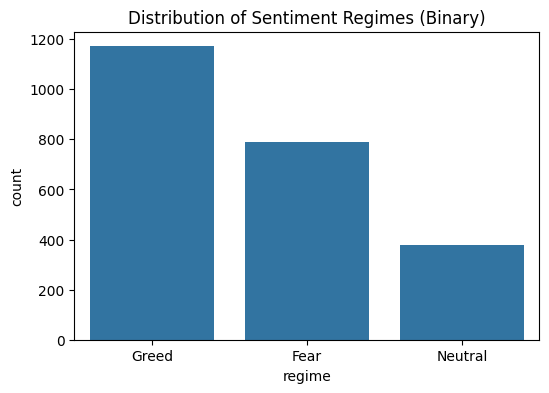

In [67]:
# Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=merged_data, x='regime')
plt.title("Distribution of Sentiment Regimes (Binary)")
plt.show()


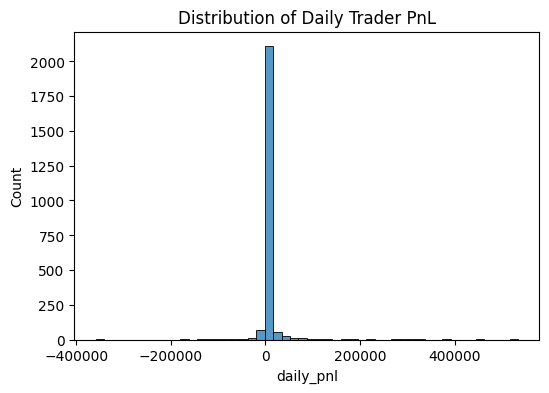

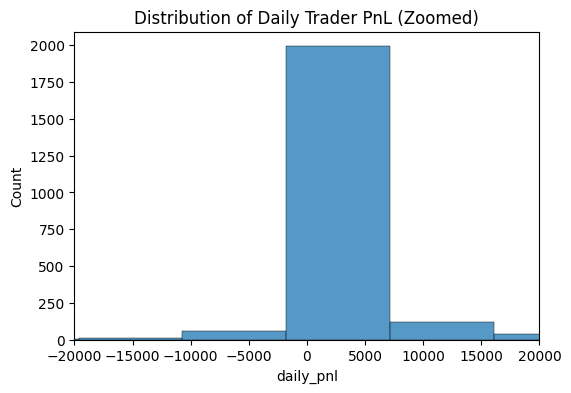

In [52]:
# Distribution of Daily PnL
plt.figure(figsize=(6,4))
sns.histplot(merged_data['daily_pnl'], bins=50)
plt.title("Distribution of Daily Trader PnL")
plt.show()

 #Zoomed View
plt.figure(figsize=(6,4))
sns.histplot(merged_data['daily_pnl'], bins=100)
plt.xlim(-20000, 20000)
plt.title("Distribution of Daily Trader PnL (Zoomed)")
plt.show()


The daily PnL distribution is highly skewed with heavy tails, which is typical for financial return data.

Most trader-days cluster near zero profitability, while a small number of extreme gains and losses create long tails on both sides.

Due to this skewness:
- Median comparisons will be more informative than means.
- Non-parametric statistical tests may be preferred in regime comparisons.


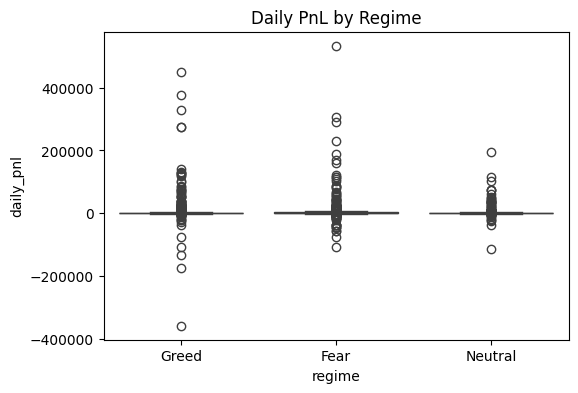

In [68]:
# Daily PnL by Sentiment Regime
plt.figure(figsize=(6,4))
sns.boxplot(data=merged_data, x='regime', y='daily_pnl')
plt.title("Daily PnL by Regime")
plt.show()


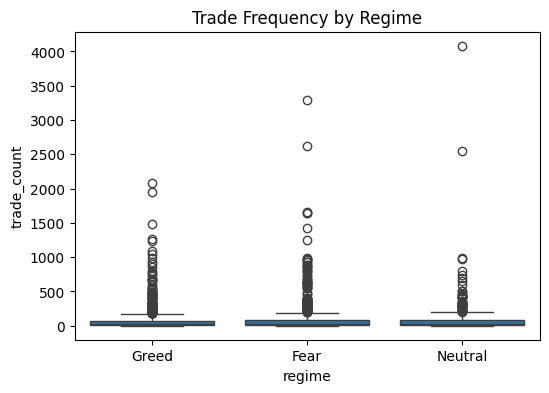

In [69]:
plt.figure(figsize=(6,4))
sns.boxplot(data=merged_data, x='regime', y='trade_count')
plt.title("Trade Frequency by Regime")
plt.show()


## 4. Regime-Based Statistical Comparison

This section evaluates whether trader performance and behavior differ between Fear and Greed market regimes.

Given the heavy-tailed nature of financial return distributions observed earlier, we compare both:

- Mean and median values
- Distribution differences using non-parametric statistical testing

We analyze:

- Daily PnL (performance)
- Win rate (trade quality)
- Trade frequency (behavior)
- PnL volatility (risk exposure)

The goal is to determine whether sentiment regimes meaningfully influence trader outcomes and risk-taking behavior.


In [70]:
#  Daily PnL Comparison

pnl_summary = merged_data.groupby('regime')['daily_pnl'].agg(
    mean_pnl='mean',
    median_pnl='median',
    std_pnl='std',
    count='count'
).reset_index()

pnl_summary


,regime,mean_pnl,median_pnl,std_pnl,count
0,Fear,5185.1464,122.7370,31224.1488,790
1,Greed,4154.8254,267.8462,29288.7626,1171
2,Neutral,3542.1556,168.0235,17540.2306,377


### Observations – Daily PnL

- Mean daily PnL is highest during Fear regimes (~$5,185) compared to Greed (~$4,155).
- However, median PnL is higher during Greed (~$268) compared to Fear (~$123).
- This divergence between mean and median confirms the heavy-tailed nature of the PnL distribution.
- Fear regimes exhibit higher volatility (std ≈ 31,224), indicating greater dispersion in outcomes.

Interpretation:
While Fear periods generate higher average PnL due to extreme positive outliers, Greed regimes show stronger typical (median) profitability. This suggests that Fear markets may produce occasional large gains but with higher uncertainty.


In [ ]:
#  Win Rate Comparison
winrate_summary = merged_data.groupby('regime')['win_rate'].agg(
    mean_winrate='mean',
    median_winrate='median'
).reset_index()

winrate_summary


,regime,mean_winrate,median_winrate
0,Fear,0.3571,0.3122
1,Greed,0.3639,0.3333
2,Neutral,0.3571,0.3240


### Observations – Win Rate

- Mean win rate is slightly higher during Greed regimes (~36.4%) compared to Fear (~35.7%).
- Median win rate follows the same pattern.
- Differences are modest but directionally consistent.

Interpretation:
Traders appear marginally more consistent during Greed regimes. This may reflect more predictable price movements or stronger trend-following behavior in optimistic markets.


In [72]:
#  Trade Frequency Comparison
trade_summary = merged_data.groupby('regime')['trade_count'].agg(
    mean_trades='mean',
    median_trades='median',
    std_trades='std'
).reset_index()

trade_summary

,regime,mean_trades,median_trades,std_trades
0,Fear,105.3494,31.0000,246.1526
1,Greed,77.0820,28.0000,160.8497
2,Neutral,99.9788,29.0000,278.9591


### Observations – Trade Frequency

- Traders execute significantly more trades during Fear regimes (mean ≈ 105) compared to Greed (mean ≈ 77).
- Median trade counts are relatively similar across regimes (28–31).
- Fear regimes exhibit substantially higher dispersion in trade frequency.

Interpretation:
Fear regimes appear to trigger increased trading activity, possibly due to heightened volatility or reactive behavior. This suggests traders may respond more aggressively during uncertain markets.


In [73]:
# Volatility Comparison (Risk Exposure)
# Daily PnL Volatility by Regime
volatility_summary = merged_data.groupby('regime')['daily_pnl'].std().reset_index()
volatility_summary.columns = ['regime', 'pnl_volatility']

volatility_summary

,regime,pnl_volatility
0,Fear,31224.1488
1,Greed,29288.7626
2,Neutral,17540.2306


### Observations – PnL Volatility

- PnL volatility is highest during Fear regimes.
- Greed also shows elevated volatility but lower than Fear.
- Neutral markets exhibit substantially lower dispersion.

Interpretation:
Risk exposure and outcome variability increase during Fear regimes, reinforcing the idea that uncertain markets amplify both gains and losses.


In [74]:
# Statistical Testing
# Mann-Whitney U Test (Fear vs Greed)

from scipy.stats import mannwhitneyu

# Filter only Fear and Greed (exclude Neutral)
fear_data = merged_data[merged_data['regime'] == 'Fear']['daily_pnl']
greed_data = merged_data[merged_data['regime'] == 'Greed']['daily_pnl']

stat, p_value = mannwhitneyu(fear_data, greed_data, alternative='two-sided')

print("Mann-Whitney U Statistic:", stat)
print("P-value:", p_value)


Mann-Whitney U Statistic: 439208.0
P-value: 0.05508394906890468


### Statistical Test – Daily PnL (Fear vs Greed)

The Mann–Whitney U test yields a p-value of approximately 0.055.

This is slightly above the conventional 0.05 significance threshold, suggesting:

- There is weak but not statistically strong evidence that PnL distributions differ between Fear and Greed regimes.
- The observed differences may be economically meaningful but are not strongly statistically significant at the 5% level.

Interpretation:
While performance characteristics vary across regimes (mean, median, volatility), the difference in central tendency is borderline significant. The stronger signal appears to lie in volatility and behavioral shifts rather than pure profitability differences.


## 5. Trader Segmentation & Regime Sensitivity Analysis

While earlier sections evaluated overall differences between Fear and Greed regimes, aggregated averages may conceal important heterogeneity across traders.

Different trader types may respond differently to market sentiment. For example:

- High-frequency traders may increase activity during volatile Fear periods.
- Lower-activity traders may perform more consistently during stable Greed markets.

To uncover these differences, we segment traders based on behavioral characteristics and analyze how each segment performs under different sentiment regimes.

This helps identify whether sentiment sensitivity is uniform across traders or concentrated within specific trader groups.


In [ ]:
# Trader-Level Aggregation

trader_summary = merged_data.groupby('Account').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    pnl_volatility=('daily_pnl', 'std'),
    avg_trade_count=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_long_ratio=('long_ratio', 'mean'),
    total_trading_days=('daily_pnl', 'count')
).reset_index()

print("Trader-level dataset shape:", trader_summary.shape)
trader_summary.head()

Trader-level dataset shape: (32, 8)


,Account,avg_daily_pnl,pnl_volatility,avg_trade_count,avg_trade_size,avg_win_rate,avg_long_ratio,total_trading_days
0,0x083384f897ee0f19899168e3b1bec365f52a9012,66676.2425,150401.7973,159.0833,17759.7314,0.3523,0.4922,24
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,920.8715,3603.0423,139.9808,4354.7886,0.3972,0.4369,52
2,0x271b280974205ca63b716753467d5a371de622ab,-5869.6826,33420.4100,317.4167,9758.6092,0.3800,0.4012,12
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,817.6840,2993.2847,82.1605,484.8505,0.4525,0.4958,162
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,2444.3189,4867.7435,46.9420,2507.6944,0.4987,0.3698,69


Each row now represents a trader aggregated across the full dataset.

The features capture:

- Average profitability
- Risk (PnL volatility)
- Trading intensity
- Position size behavior
- Trade quality (win rate)
- Directional bias


In [77]:
# Activity-Based Segmentation

activity_threshold = trader_summary['avg_trade_count'].median()

trader_summary['activity_segment'] = np.where(
    trader_summary['avg_trade_count'] >= activity_threshold,
    'High Activity',
    'Low Activity'
)

print("Activity threshold (median):", activity_threshold)
trader_summary['activity_segment'].value_counts()

Activity threshold (median): 59.56063034188034


activity_segment
High Activity    16
Low Activity     16
Name: count, dtype: int64

In [84]:
#  Merge Segment Labels

merged_data = merged_data.merge(
    trader_summary[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

merged_data.head()

,Account,trade_date,daily_pnl,trade_count,daily_volume_usd,avg_trade_size,win_rate,long_ratio,classification,value,regime,activity_segment_x,activity_segment_y,activity_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,177,900880.1300,5089.7182,0.0000,0.0000,Extreme Greed,76.0000,Greed,High Activity,High Activity,High Activity
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,68,542413.1800,7976.6644,0.0000,0.0000,Extreme Greed,90.0000,Greed,High Activity,High Activity,High Activity
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,40,372495.5580,9312.3890,0.0000,0.0000,Extreme Greed,83.0000,Greed,High Activity,High Activity,High Activity
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,12,338240.0000,28186.6667,0.0000,1.0000,Extreme Greed,94.0000,Greed,High Activity,High Activity,High Activity
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,27,383164.0360,14191.2606,0.4444,0.4444,Extreme Greed,79.0000,Greed,High Activity,High Activity,High Activity


In [85]:
# Segment-Level Regime Comparison

segment_regime_summary = merged_data.groupby(
    ['activity_segment', 'regime']
)['daily_pnl'].agg(
    mean_pnl='mean',
    median_pnl='median',
    std_pnl='std',
    count='count'
).reset_index()

segment_regime_summary


,activity_segment,regime,mean_pnl,median_pnl,std_pnl,count
0,High Activity,Fear,7955.4437,330.0399,41229.7172,387
1,High Activity,Greed,4952.6472,601.5109,30492.4769,480
2,High Activity,Neutral,4130.2774,368.9589,18585.0373,166
3,Low Activity,Fear,2524.8362,1.1753,16334.0434,403
4,Low Activity,Greed,3600.6222,88.5070,28431.8474,691
5,Low Activity,Neutral,3079.4627,27.2478,16702.7026,211


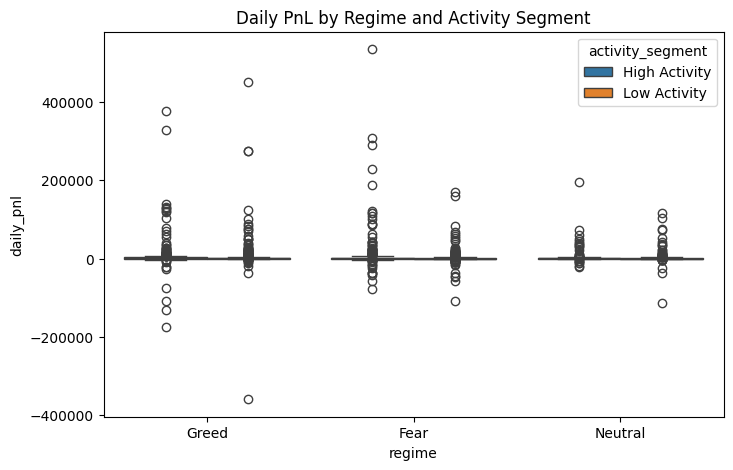

In [86]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=merged_data,
    x='regime',
    y='daily_pnl',
    hue='activity_segment'
)
plt.title("Daily PnL by Regime and Activity Segment")
plt.show()


### Observations – Regime Sensitivity by Activity Segment

- Median daily PnL appears relatively similar across activity segments within each regime.
- However, High Activity traders exhibit significantly larger dispersion in daily PnL, particularly during Fear regimes.
- Fear periods amplify both positive and negative extremes, especially for High Activity traders.
- Neutral markets show comparatively lower volatility across both segments.

Interpretation:

While average profitability does not differ dramatically by activity level, risk exposure does. High Activity traders appear more sensitive to sentiment-driven volatility, particularly during Fear regimes. This suggests that trader activity level interacts with market sentiment to influence risk outcomes more strongly than central profitability.


## 6. Strategy Recommendations

Based on the regime-based performance analysis and trader segmentation findings, we propose sentiment-aware strategy adjustments.

The objective is not to predict markets, but to adapt trading behavior dynamically according to observed regime-dependent patterns in volatility and trader sensitivity.


### Strategy 1: Dynamic Risk Adjustment in Fear Regimes

Finding:
Fear regimes exhibit significantly higher PnL volatility and increased trading activity, particularly among High Activity traders.

Recommendation:
- Reduce leverage or position sizing during Fear regimes.
- Implement tighter stop-loss thresholds for High Activity traders.
- Avoid increasing trade frequency reactively during high-uncertainty periods.

Rationale:
While Fear markets generate occasional large gains, they also amplify downside risk. Risk-adjusted performance may improve by reducing exposure during high-volatility sentiment regimes.


### Strategy 2: Favor Stable Positioning During Greed Regimes

Finding:
Greed regimes show higher median PnL and slightly improved win rates compared to Fear regimes, with lower overall volatility.

Recommendation:
- Maintain or moderately increase exposure during Greed regimes.
- Favor trend-following or momentum-based strategies.
- Encourage consistent trade sizing rather than aggressive scaling.

Rationale:
Greed markets appear to offer more stable and predictable profitability, making them better suited for capital deployment with controlled risk.


### Strategy 3: Segment-Specific Regime Adjustment

Finding:
High Activity traders exhibit significantly larger performance dispersion during Fear regimes compared to Low Activity traders.

Recommendation:
- Apply stricter risk controls to High Activity traders during Fear regimes.
- Allow Low Activity traders to maintain stable exposure.
- Consider activity-adjusted risk limits tied to sentiment regime.

Rationale:
Sentiment sensitivity is not uniform across traders. Activity level amplifies volatility effects, suggesting that regime-aware risk management should be segment-specific rather than universally applied.


## 7. Conclusion

This analysis demonstrates that while overall profitability differences between Fear and Greed regimes are modest, volatility and behavioral shifts are significant.

Key findings:

- Fear regimes increase trading intensity and outcome dispersion.
- Greed regimes show slightly more consistent profitability.
- High Activity traders are more sensitive to sentiment-driven volatility.

The strongest actionable insight lies in dynamic risk management rather than regime-based directional prediction. Sentiment-aware exposure control may improve risk-adjusted performance more effectively than attempting to forecast raw returns.


## 8. Bonus – Predictive Modeling

To extend the analysis beyond descriptive statistics, we build a simple predictive model to classify whether a trader will be profitable on the next trading day.

The objective is not to build a production trading system, but to evaluate whether sentiment and behavioral features contain predictive signal for short-term profitability.


In [87]:
# Create Next-Day Target

# Sort properly
merged_data = merged_data.sort_values(['Account', 'trade_date'])

# Create next-day pnl
merged_data['next_day_pnl'] = merged_data.groupby('Account')['daily_pnl'].shift(-1)

# Create binary profitability label
merged_data['next_day_profitable'] = np.where(
    merged_data['next_day_pnl'] > 0, 1, 0
)

# Drop rows with missing target
model_data = merged_data.dropna(subset=['next_day_profitable'])

model_data.head()

,Account,trade_date,daily_pnl,trade_count,daily_volume_usd,avg_trade_size,win_rate,long_ratio,classification,value,regime,activity_segment_x,activity_segment_y,activity_segment,next_day_pnl,next_day_profitable
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,177,900880.1300,5089.7182,0.0000,0.0000,Extreme Greed,76.0000,Greed,High Activity,High Activity,High Activity,0.0000,0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,68,542413.1800,7976.6644,0.0000,0.0000,Extreme Greed,90.0000,Greed,High Activity,High Activity,High Activity,0.0000,0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,40,372495.5580,9312.3890,0.0000,0.0000,Extreme Greed,83.0000,Greed,High Activity,High Activity,High Activity,-21227.0000,0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,12,338240.0000,28186.6667,0.0000,1.0000,Extreme Greed,94.0000,Greed,High Activity,High Activity,High Activity,1603.1000,1
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,27,383164.0360,14191.2606,0.4444,0.4444,Extreme Greed,79.0000,Greed,High Activity,High Activity,High Activity,-132271.0000,0


In [92]:
# Feature Selection

features = [
    'daily_pnl',
    'trade_count',
    'daily_volume_usd',
    'avg_trade_size',
    'win_rate',
    'long_ratio',
    'value'  # numeric sentiment score
]

# Remove rows with missing feature values
model_data_clean = model_data.dropna(subset=features)

X = model_data_clean[features]
y = model_data_clean['next_day_profitable']

print("Clean modeling dataset shape:", X.shape)


Clean modeling dataset shape: (2337, 7)


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1635, 7)
Test shape: (702, 7)


In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", round(accuracy, 4))
print("ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6652
ROC-AUC: 0.6412

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.23      0.34       256
           1       0.67      0.91      0.78       446

    accuracy                           0.67       702
   macro avg       0.64      0.57      0.56       702
weighted avg       0.65      0.67      0.62       702



### Predictive Model Results

The logistic regression model was trained to predict next-day profitability using behavioral and sentiment features.

Model Performance:
- Accuracy: 66.52%
- ROC-AUC: 0.6412

Classification Breakdown:
- Class 1 (Profitable Days): High recall (0.91)
- Class 0 (Non-Profitable Days): Lower recall (0.23)

Interpretation:

The model achieves moderate predictive performance, with accuracy (~66.5%) exceeding random baseline expectations and a ROC-AUC of 0.64 indicating modest discriminatory power.

The high recall for profitable days (0.91) suggests the model is effective at identifying positive-return days. However, lower recall for non-profitable days (0.23) indicates limited ability to detect downside outcomes.

This asymmetry is common in financial prediction tasks where class imbalance and return noise make loss prediction particularly difficult.

Overall, the model demonstrates that behavioral and sentiment features contain measurable signal, but the predictive strength is limited. This aligns with earlier findings that sentiment more strongly influences volatility and risk dispersion rather than providing strong directional forecasting power.

These results suggest that sentiment-aware risk management may be more practical and robust than attempting short-term return prediction.


In [95]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

feature_importance


,Feature,Coefficient
1,trade_count,0.4573
4,win_rate,0.3436
5,long_ratio,0.1705
6,value,0.1115
2,daily_volume_usd,-0.0257
0,daily_pnl,-0.0477
3,avg_trade_size,-0.0525


## 9. Clustering Traders into Behavioral Archetypes

To further understand heterogeneity across traders, we apply unsupervised clustering to group traders into behavioral archetypes based on their aggregated performance and activity characteristics.

This helps identify distinct trader types such as:
- High-risk aggressive traders
- Stable consistent traders
- Low-activity conservative traders

Clustering allows sentiment-aware strategies to be tailored to trader behavior rather than applied uniformly.


In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_features = [
    'avg_daily_pnl',
    'pnl_volatility',
    'avg_trade_count',
    'avg_trade_size',
    'avg_win_rate',
    'avg_long_ratio'
]

X_cluster = trader_summary[cluster_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
trader_summary.loc[X_cluster.index, 'cluster'] = kmeans.fit_predict(X_scaled)

trader_summary['cluster'].value_counts()

cluster
0.0000    19
1.0000    12
2.0000     1
Name: count, dtype: int64

In [ ]:
cluster_summary = trader_summary.groupby('cluster')[cluster_features].mean()
cluster_summary

,avg_daily_pnl,pnl_volatility,avg_trade_count,avg_trade_size,avg_win_rate,avg_long_ratio
cluster,,,,,,
0.0000,5366.7835,16278.8160,153.3389,8345.1474,0.3827,0.5464
1.0000,5029.8259,23421.9119,45.0148,3157.4720,0.3055,0.3812
2.0000,66676.2425,150401.7973,159.0833,17759.7314,0.3523,0.4922


### Behavioral Archetypes Identified

Clustering reveals three distinct trader archetypes with materially different risk and activity profiles.

---

Cluster 0 – Active & Controlled Traders

- High trading frequency (~153 trades/day)
- Moderate position size (~$8,345)
- Relatively high win rate (~38.3%)
- Moderate volatility (~16k)

Interpretation:
These traders are highly active but maintain comparatively controlled risk exposure. Despite frequent trading, their volatility is lower than Cluster 1 and dramatically lower than Cluster 2. This suggests disciplined position management and relatively stable performance.

---

Cluster 1 – Low Activity & Lower Precision Traders

- Lower trade frequency (~45 trades/day)
- Small position size (~$3,157)
- Lowest win rate (~30.5%)
- Moderate-to-high volatility (~23k)

Interpretation:
This group trades less frequently and with smaller size, yet exhibits higher volatility than Cluster 0. The combination of lower win rate and elevated dispersion suggests weaker trade selection or less effective risk control.

---

Cluster 2 – High-Risk, High-Return Traders (Outlier Group)

- Very high average daily PnL (~$66k)
- Extremely high volatility (~150k)
- High trade frequency (~159 trades/day)
- Largest position size (~$17,759)

Interpretation:
Cluster 2 represents aggressive, high-capital traders with substantial risk exposure. Their profitability is significantly higher, but so is volatility. This group likely includes high-leverage or large-capital participants whose performance is highly sensitive to market conditions.

---

Overall Insight:

Trader behavior is highly heterogeneous. While Clusters 0 and 1 represent more typical participants, Cluster 2 represents a small group of high-risk, high-reward traders. 

This reinforces earlier findings that volatility and risk exposure vary more dramatically across trader types than average profitability alone suggests.
